<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 1: Intro, EDA and Preprocessing

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

## Goal: 

*This is a project for learning purposes. The *** is not involved with this project in any way.*

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Imports, Reading in the Data, and Initial EDA

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [90.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,937

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries, packages and modules

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from itertools import chain
import os

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from IPython.display import HTML, display
%matplotlib inline

In [4]:
# Check colab GPU info

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [5]:
# Set text to wrap in Google colab notebook

def set_css():
    display(HTML('''
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
# Initialize Spark Session

# spark = SparkSession.builder.master('local[*]').getOrCreate()
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark.version

'3.3.0'

### Description of Features

**Dataset 1 – Transactions:**

`MessageId` - Globally unique identifier within this dataset for individual transactions<br>
`UETR` - The Unique End-to-end Transaction Reference—a 36-character string enabling traceability of all individual transactions associated with a single end-to-end transaction<br>
`TransactionReference` - Unique identifier for an individual transaction<br>
`Timestamp` - Time at which the individual transaction was initiated<br>
`Sender` - Institution (bank) initiating/sending the individual transaction<br>
`Receiver` - Institution (bank) receiving the individual transaction<br>
`OrderingAccount` - Account identifier for the originating ordering entity (individual or organization) for end-to-end transaction<br>
`OrderingName` - Name for the originating ordering entity<br>
`OrderingStreet` - Street address for the originating ordering entity<br>
`OrderingCountryCityZip` - Remaining address details for the originating ordering entity<br>
`BeneficiaryAccount` - Account identifier for the final beneficiary entity (individual or organization) for end-to-end transaction<br>
`BeneficiaryName` - Name for the final beneficiary entity<br>
`BeneficiaryStreet` - Street address for the final beneficiary entity<br>
`BeneficiaryCountryCityZip` - Remaining address details for the final beneficiary entity<br>
`SettlementDate` - Date the individual transaction was settled<br>
`SettlementCurrency` - Currency used for transaction<br>
`SettlementAmount` - Value of the transaction net of fees/transfer charges/forex<br>
`InstructedCurrency` - Currency of the individual transaction as instructed to be paid by the Sender<br>
`InstructedAmount` - Value of the individual transaction as instructed to be paid by the Sender<br>
`Label` - Boolean indicator of whether the transaction is anomalous or not. This is the target variable for the prediction task.<br>
<br>
**Dataset 2 – Banks:**

`Bank` - Identifier for the bank<br>
`Account` - Identifier for the account<br>
`Name` - Name of the account<br>
`Street` - Street address associated with the account<br>
`CountryCityZip` - Remaining address details associated with the account<br>
`Flags` - Enumerated data type indicating potential issues or special features that have been associated with an account. Flag definitions are below:<br>
00 - No flags<br>
01 - Account closed<br>
03 - Account recently opened<br>
04 - Name mismatch<br>
05 - Account under monitoring<br>
06 - Account suspended<br>
07 - Account frozen<br>
08 - Non-transaction account<br>
09 - Beneficiary deceased<br>
10 - Invalid company ID<br>
11 - Invalid individual ID<br>

### Read in Data

In [7]:
# Read in transactions data csv file to a Spark DataFrame
train_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_train_dataset.csv', header=True, inferSchema=True)
test_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_test_dataset.csv', header=True, inferSchema=True)

# Persist in memory
train_df = train_df.cache()
test_df = test_df.cache()

# Read in banks data csv file to a Spark DataFrame
# banks_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/bank_dataset.csv', header=True, inferSchema=True)

### Initial EDA

In [8]:
# Print shape of dataframes
print(f"train_df:  {train_df.count():,} Rows, {len(train_df.columns)} Columns")
print(f"test_df:  {test_df.count():,} Rows, {len(test_df.columns)} Columns")
# print(f"banks_df:  {banks_df.count():,} Rows, {len(banks_df.columns)} Columns")

train_df:  4,691,725 Rows, 20 Columns
test_df:  705,108 Rows, 20 Columns


In [9]:
train_df.printSchema()

root
 |-- MessageId: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- UETR: string (nullable = true)
 |-- Sender: string (nullable = true)
 |-- Receiver: string (nullable = true)
 |-- TransactionReference: string (nullable = true)
 |-- OrderingAccount: string (nullable = true)
 |-- OrderingName: string (nullable = true)
 |-- OrderingStreet: string (nullable = true)
 |-- OrderingCountryCityZip: string (nullable = true)
 |-- BeneficiaryAccount: string (nullable = true)
 |-- BeneficiaryName: string (nullable = true)
 |-- BeneficiaryStreet: string (nullable = true)
 |-- BeneficiaryCountryCityZip: string (nullable = true)
 |-- SettlementDate: integer (nullable = true)
 |-- SettlementCurrency: string (nullable = true)
 |-- SettlementAmount: double (nullable = true)
 |-- InstructedCurrency: string (nullable = true)
 |-- InstructedAmount: double (nullable = true)
 |-- Label: integer (nullable = true)



In [ ]:
# banks_df.printSchema()

In [11]:
# Display first row of train_df
train_df.show(n=1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------
 MessageId                 | TRA7CGN3FF                           
 Timestamp                 | 2022-01-01 00:00:00                  
 UETR                      | f474fdb3-4675-4fff-ab7e-3469f82bd6a7 
 Sender                    | DPSUFRPP                             
 Receiver                  | ABVVUS6S                             
 TransactionReference      | PETX22-FXIDA-7054                    
 OrderingAccount           | FR90714755422956984353               
 OrderingName              | PHACELIA HETEROPHYLLA                
 OrderingStreet            | 3| RUE HAMON                         
 OrderingCountryCityZip    | FR/42859 SAINTE AURÉLIE              
 BeneficiaryAccount        | 611024064274704358                   
 BeneficiaryName           | PAPAVER CALIFORNICUM                 
 BeneficiaryStreet         | 2584 CHARLES PLACE                   
 BeneficiaryCountryCityZip | US/ROJASLAND| DC 58442           

In [ ]:
# Display first 5 rows of banks dataframe
# banks_df.show(n=5, truncate=False)

In [13]:
# Print number of null/missing values in each column of train_df
train_df_null = train_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in train_df.columns if c != 'Timestamp'])

print('Number of null/missing values per column:\n')
train_df_null.show(vertical=True, truncate=False)

Number of null/missing values per column:

-RECORD 0------------------------
 MessageId                 | 0   
 UETR                      | 0   
 Sender                    | 0   
 Receiver                  | 0   
 TransactionReference      | 0   
 OrderingAccount           | 0   
 OrderingName              | 107 
 OrderingStreet            | 0   
 OrderingCountryCityZip    | 0   
 BeneficiaryAccount        | 0   
 BeneficiaryName           | 103 
 BeneficiaryStreet         | 0   
 BeneficiaryCountryCityZip | 0   
 SettlementDate            | 0   
 SettlementCurrency        | 0   
 SettlementAmount          | 0   
 InstructedCurrency        | 0   
 InstructedAmount          | 0   
 Label                     | 0   



In [ ]:
# Print number of null/missing values in each column of banks_df
# banks_df_null = banks_df.select([F.count(F.when(F.col(c).contains('None') | \
#                                                 F.col(c).contains('NULL') | \
#                                                 (F.col(c) == '' ) | \
#                                                 F.col(c).isNull() | \
#                                                 F.isnan(c), c ))\
#                                  .alias(c) for c in banks_df.columns])

# print('Number of null/missing values per column:\n')
# banks_df_null.show(vertical=True, truncate=False)

In [14]:
# Print number of unique values in each column in train_df; sample 1% of df for efficiency
train_df_unique = train_df.sample(False, 0.01).agg(*(F.countDistinct(F.col(c)) for c in train_df.columns))

print(f"Number of unique values per column (in sample of 1% of dataframe):\n")
train_df_unique.show(vertical=True, truncate=False)

Number of unique values per column (in sample of 1% of dataframe):

-RECORD 0---------------------------------
 count(MessageId)                 | 46730 
 count(Timestamp)                 | 19566 
 count(UETR)                      | 46661 
 count(Sender)                    | 15    
 count(Receiver)                  | 21    
 count(TransactionReference)      | 29079 
 count(OrderingAccount)           | 40886 
 count(OrderingName)              | 24096 
 count(OrderingStreet)            | 38985 
 count(OrderingCountryCityZip)    | 36800 
 count(BeneficiaryAccount)        | 33701 
 count(BeneficiaryName)           | 21565 
 count(BeneficiaryStreet)         | 28299 
 count(BeneficiaryCountryCityZip) | 28076 
 count(SettlementDate)            | 23    
 count(SettlementCurrency)        | 4     
 count(SettlementAmount)          | 46728 
 count(InstructedCurrency)        | 6     
 count(InstructedAmount)          | 46659 
 count(Label)                     | 2     



In [ ]:
# Print number of unique values in each column in banks_df; sample 10% of df for efficiency
# banks_df_unique = banks_df.sample(False, 0.1).agg(*(F.countDistinct(F.col(c)) for c in banks_df.columns))

# print(f"Number of unique values per column (in sample of 10% of dataframe):\n")
# banks_df_unique.show(vertical=True, truncate=False)

In [15]:
# Display Pandas style summary statistics table of numeric columns
num_cols = [item[0] for item in train_df.dtypes if item[1] == 'int' or item[1] == 'double']

train_df.select(num_cols).summary().show(truncate=False)


+-------+------------------+---------------------+--------------------+---------------------+
|summary|SettlementDate    |SettlementAmount     |InstructedAmount    |Label                |
+-------+------------------+---------------------+--------------------+---------------------+
|count  |4691725           |4691725              |4691725             |4691725              |
|mean   |220111.88223073602|5.074057103357817E9  |9.416309758961706E9 |0.0010443919880214632|
|stddev |6.674532853334336 |2.7276372846653574E11|3.858897596339895E11|0.03230017733337347  |
|min    |220101            |0.67                 |0.67                |0                    |
|25%    |220106            |2237846.0            |2174568.32          |0                    |
|50%    |220112            |4623703.18           |4283045.1           |0                    |
|75%    |220118            |1.913998868E7        |1.981570822E7       |0                    |
|max    |220123            |5.6469401543203E13   |5.65016526

In [16]:
# Display unique currencies used in transactions
print('train_df:')
train_df.select('InstructedCurrency').distinct().show()

train_df:
+------------------+
|InstructedCurrency|
+------------------+
|               NZD|
|               GBP|
|               CAD|
|               EUR|
|               AUD|
|               JPY|
|               INR|
|               USD|
+------------------+



In [17]:
# Display value counts for 'Label' column (classification target) in train_df
class_counts = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())

class_counts.show(truncate=10)

+-----+-------+----------+
|Label|  count|   percent|
+-----+-------+----------+
|    1|   4900|0.00104...|
|    0|4686825|0.99895...|
+-----+-------+----------+



**Remarks:**
- It looks like this is an extremely imbalanced dataset - only about 0.1% of the data is in the positive class. We will need to address this class imbalance as part of the modeling process.

<br>

# Detailed EDA

In [109]:
viz_df = train_df.sample(withReplacement=False, fraction=0.02, seed=42).toPandas()

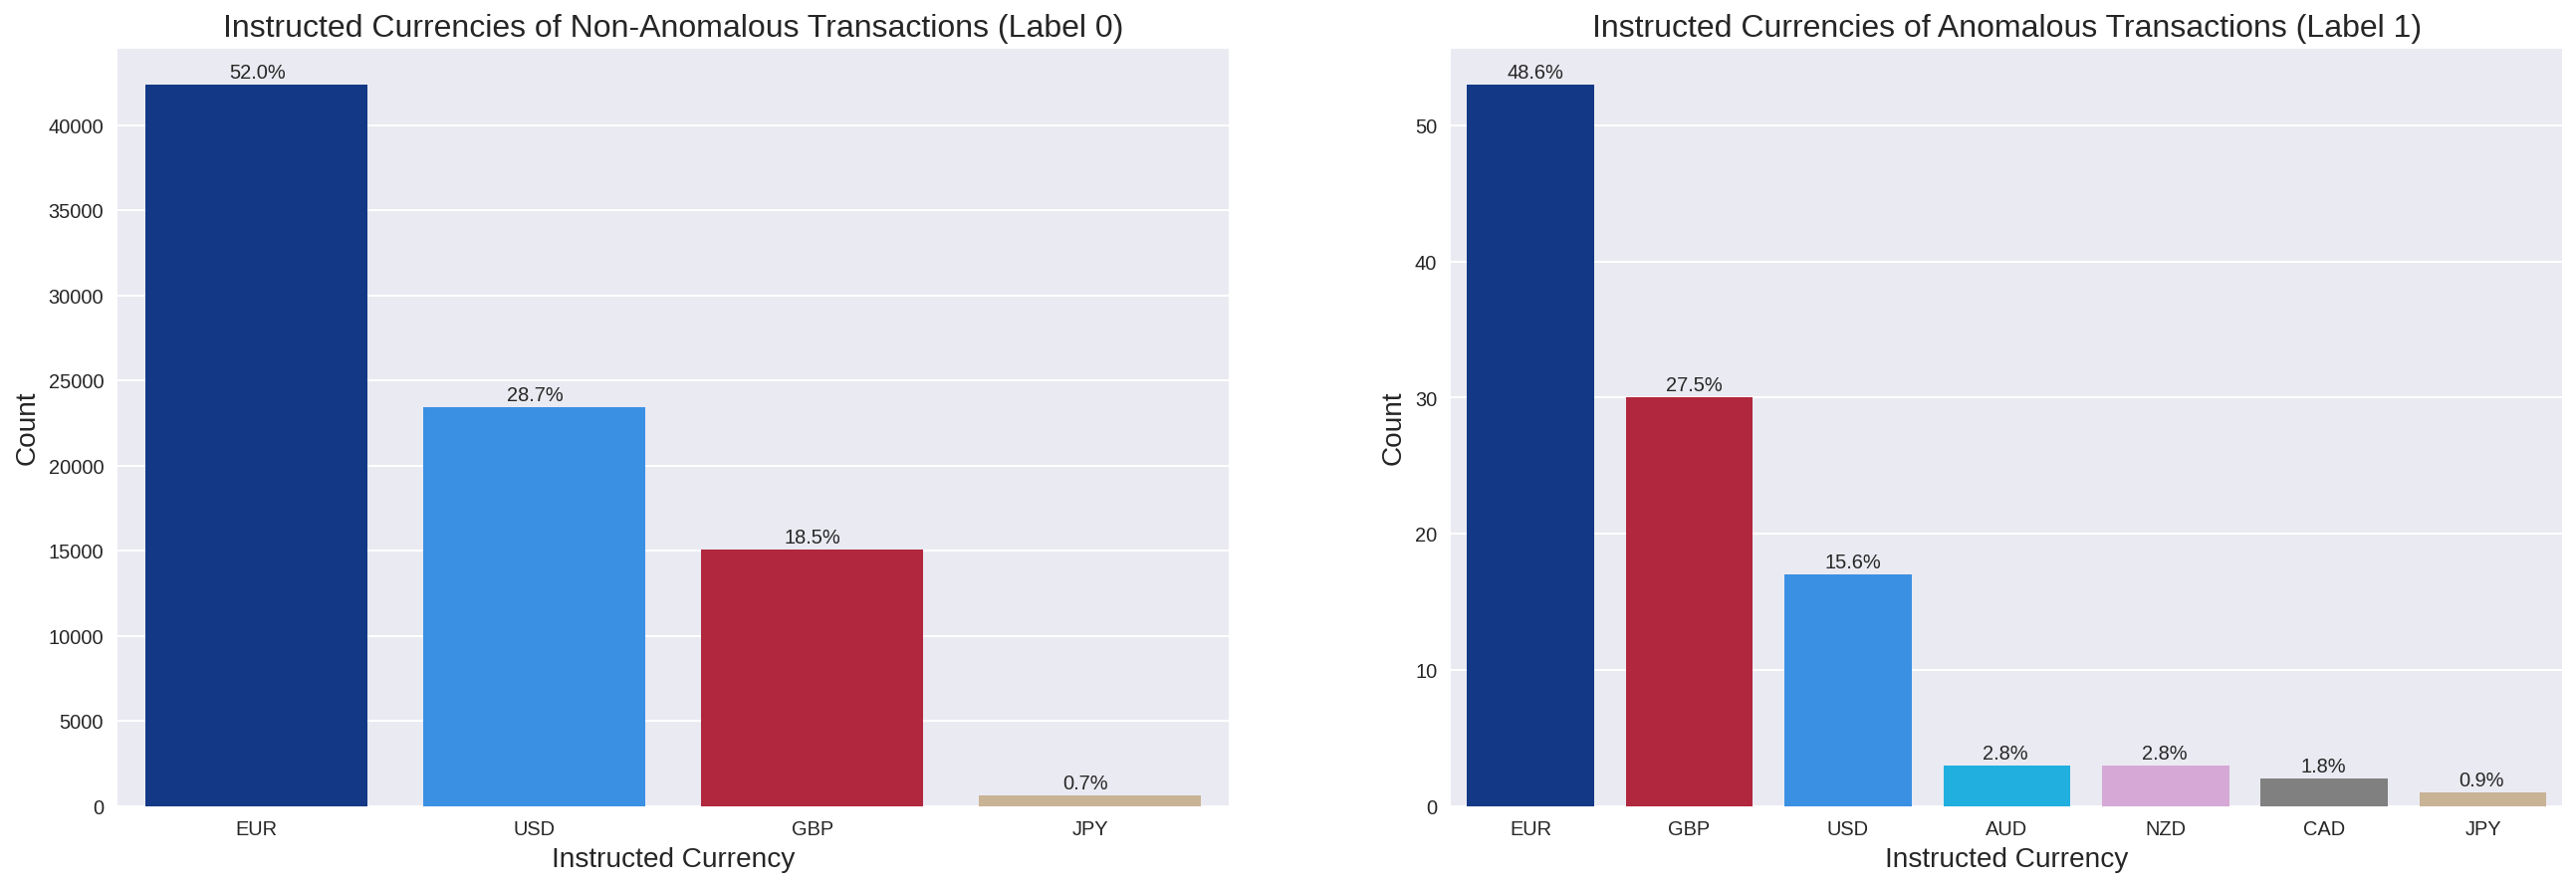

In [139]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 7))

# Set consistent color palettes
ax1_palette = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}
ax2_palette = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan', \
               'AUD': 'deepskyblue', 'CAD': 'gray', 'NZD': 'plum'}

# Plot countplots
sns.countplot(x='InstructedCurrency', data=viz_df.loc[viz_df.Label == 0], ax=ax1, 
              order=viz_df.loc[viz_df.Label == 0]['InstructedCurrency'].value_counts().index, 
              palette=ax1_palette)
sns.countplot(x='InstructedCurrency', data=viz_df.loc[viz_df.Label == 1], ax=ax2, 
              order=viz_df.loc[viz_df.Label == 1]['InstructedCurrency'].value_counts().index, 
              palette=ax2_palette)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df.loc[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.3
    txt_y = p.get_height()+400
    ax1.text(txt_x,txt_y,txt)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df.loc[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.25
    txt_y = p.get_height()+0.5
    ax2.text(txt_x,txt_y,txt)

ax1.set_title('Instructed Currencies of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Instructed Currency', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax2.set_title('Instructed Currencies of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Instructed Currency', fontsize=14)
ax2.set_ylabel('Count', fontsize=14);

<br>

# Preprocessing & Feature Engineering

Steps:
1. Drop duplicate transaction rows
2. Train/test split
3. Create `SenderHourFreq` feature
4. Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features
5. Create `SenderReceiverFreq` feature

In [ ]:
# Specify join condition
# join_condition = (transactions_df.OrderingAccount == banks_df.Account) | (transactions_df.BeneficiaryAccount == banks_df.Account)

# Join dataframes
# preprocessed_df = transactions_df.join(banks_df, on=join_condition, how='left')

# Unpersist old dataframes from memory
# display(transactions_df.unpersist())
# display(banks_df.unpersist())

In [ ]:
# Print shape of joined dataframe
# print(f"{preprocessed_df.count():,} Rows, {len(preprocessed_df.columns)} Columns")

### Drop intermediary transactions (only keep one row per end-to-end transaction)

In [18]:
# Print count of unique transactions (as identified by UETR codes)
print('train_df:')
train_df.select(F.countDistinct('UETR')).show()
print('test_df:')
test_df.select(F.countDistinct('UETR')).show()

train_df:
+--------------------+
|count(DISTINCT UETR)|
+--------------------+
|             4054278|
+--------------------+

test_df:
+--------------------+
|count(DISTINCT UETR)|
+--------------------+
|              651584|
+--------------------+



In [20]:
# Print total number of combined rows with duplicate UETR values (meaning sender routed transaction through one or more intermediary banks)
print('Total number of rows with intermediary transactions in train_df:')
train_df.select('UETR').groupBy('UETR')\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

Total number of rows with intermediary transactions in train_df:
+----------+
|sum(count)|
+----------+
|   1127327|
+----------+



In [21]:
# Drop rows with duplicate UETR codes, keeping the first occurence (sorted by Timestamp)
train_df = train_df.orderBy('Timestamp').coalesce(1).dropDuplicates(subset = ['UETR']).cache()
test_df = test_df.orderBy('Timestamp').coalesce(1).dropDuplicates(subset = ['UETR']).cache()

# Ensure no duplicates
assert train_df.groupBy(train_df.UETR).count().where(F.col('count') > 1).count() == 0
assert test_df.groupBy(test_df.UETR).count().where(F.col('count') > 1).count() == 0

print(f"train_df: {train_df.count()} rows")
print(f"test_df: {test_df.count()} rows")

train_df: 4054278 rows
test_df: 651584 rows


In [22]:
# Show value counts for 'Label' column (classification target) in new train and test dataframes
class_counts_train = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())
class_counts_test = test_df.groupBy('Label').count().withColumn('percent', F.col('count')/test_df.count())

print('train_df:')
class_counts_train.show(truncate=10)
print('test_df:')
class_counts_test.show(truncate=10)

train_df:
+-----+-------+----------+
|Label|  count|   percent|
+-----+-------+----------+
|    0|4049426|0.99880...|
|    1|   4852|0.00119...|
+-----+-------+----------+

test_df:
+-----+------+----------+
|Label| count|   percent|
+-----+------+----------+
|    0|650828|0.99883...|
|    1|   756|0.00116...|
+-----+------+----------+



## Feature Engineering

### Create `SenderHourFreq` feature: transaction hour frequency for each sender

This feature will tell us the frequency with which each sender initiated transactions for each hour of the day. Certain hours of the day are potentially correlated with more anomalous transactions.

In [23]:
# Define UDF to extract hour from timestamp
hour = F.udf(lambda x: x.hour, IntegerType())

# Create new column of transaction hours
train_df = train_df.withColumn('Hour', hour(train_df.Timestamp))
test_df = test_df.withColumn('Hour', hour(test_df.Timestamp))

# Create list of unique senders
senders = train_df.select('Sender').toPandas()['Sender'].unique()

# Create column of senders concatenated with hours
train_df = train_df.withColumn('SenderHour', F.concat(F.col('Sender'), F.col('Hour').cast(StringType())))
test_df = test_df.withColumn('SenderHour', F.concat(F.col('Sender'), F.col('Hour').cast(StringType())))

pd_df = train_df.select('Sender', 'Hour').toPandas()

# Create dictionary of sender hour frequency values to map from sender hour values
sender_hour_frequency = {}
for sender in senders:
    sender_rows = pd_df[pd_df['Sender'] == sender]
    for hour in range(24):
        sender_hour_frequency[sender + str(hour)] = len(sender_rows[sender_rows['Hour'] == hour])

# Create new column in train and test dataframes with sender_hour_frequency dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_hour_frequency.items())])

train_df = train_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])
test_df = test_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])

### Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features: transaction currency frequency and average transaction amount per currency for each sender

These features will tell us the frequency with which each sender initiated transactions for each currency, in the case of the first feature. For the second feature, it will tell us the average amount with which each sender sent each currency. These features may also be correlated with anomalous transactions.

In [24]:
# Create column of senders concatenated with instructed currencies
train_df = train_df.withColumn('SenderCurrency', F.concat(F.col('Sender'), F.col('InstructedCurrency')))
test_df = test_df.withColumn('SenderCurrency', F.concat(F.col('Sender'), F.col('InstructedCurrency')))

pd_train_df = train_df.select('SenderCurrency', 'InstructedAmount').toPandas()
pd_test_df = test_df.select('SenderCurrency', 'InstructedAmount').toPandas()

# Create dictionary of sender currency frequency values to map from sender currency values
sender_currency_freq = {}
# Create dictionary of average sender currency values to map from sender currency values
sender_currency_avg = {}

for sc in set(
    list(pd_train_df['SenderCurrency'].unique()) + list(pd_test_df['SenderCurrency'].unique())
):
    sender_currency_freq[sc] = len(pd_train_df[pd_train_df['SenderCurrency'] == sc])
    sender_currency_avg[sc] = pd_train_df[pd_train_df['SenderCurrency'] == sc][
        "InstructedAmount"
    ].mean()

# Create new column in train and test dataframes with sender_currency_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_freq.items())])

train_df = train_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])

# Create new column in train and test dataframes with sender_currency_avg dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_avg.items())])

train_df = train_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])

### Create `SenderReceiverFreq` feature: sender-receiver combination frequency for each sender and receiver

In [25]:
# Create column of senders concatenated with receivers
train_df = train_df.withColumn('SenderReceiver', F.concat(F.col('Sender'), F.col('Receiver')))
test_df = test_df.withColumn('SenderReceiver', F.concat(F.col('Sender'), F.col('Receiver')))

# Create dictionary of sender receiver frequency values to map from sender receiver values
sender_receiver_freq = {}

pd_train_df = train_df.select('SenderReceiver').toPandas()
pd_test_df = test_df.select('SenderReceiver').toPandas()

for sr in set(
    list(pd_train_df['SenderReceiver'].unique()) + list(pd_test_df['SenderReceiver'].unique())
):
    sender_receiver_freq[sr] = len(pd_train_df[pd_train_df['SenderReceiver'] == sr])

# Create new column in train and test dataframes with sender_receiver_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_receiver_freq.items())])

train_df = train_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])
test_df = test_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])

### Drop categorical columns

In [ ]:
cols_to_drop = [
    'Timestamp',
    'UETR',
    'Sender',
    'Receiver',
    'TransactionReference',
    'OrderingAccount',
    'OrderingName',
    'OrderingStreet',
    'OrderingCountryCityZip',
    'BeneficiaryAccount',
    'BeneficiaryName',
    'BeneficiaryStreet',
    'BeneficiaryCountryCityZip',
    'SettlementDate',
    'SettlementCurrency',
    'InstructedCurrency',
    'SenderHour',
    'SenderCurrency',
    'SenderReceiver'
]

train_df = train_df.drop(*cols_to_drop)
test_df = test_df.drop(*cols_to_drop)

In [29]:
train_df.show(5, vertical=True)

-RECORD 0-----------------------------------------
 MessageId                 | TRHSBN47QC           
 Timestamp                 | 2022-01-02 15:59:00  
 UETR                      | 0000069f-9521-407... 
 Sender                    | DPSUFRPP             
 Receiver                  | ABVVUS6S             
 TransactionReference      | PETX22-FXIDA-3010    
 OrderingAccount           | FR597147554229569... 
 OrderingName              | PLANTAGO CORONOPUS   
 OrderingStreet            | 66| RUE HENRI DIALLO 
 OrderingCountryCityZip    | FR/35912 SAINTE J... 
 BeneficiaryAccount        | 611024064274695805   
 BeneficiaryName           | FUIRENA PUMILA       
 BeneficiaryStreet         | 7897 COOK HARBORS    
 BeneficiaryCountryCityZip | US/EAST SHAWNA| C... 
 SettlementDate            | 220102               
 SettlementCurrency        | USD                  
 SettlementAmount          | 2939777.86           
 InstructedCurrency        | EUR                  
 InstructedAmount          | 26

In [ ]:
test_df.show(5)